In [1]:
import pandas as pd
import numpy as np
from scipy.io.arff import loadarff
import clustering
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import testing
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.preprocessing import OneHotEncoder

## Badanie wpływu skalowania cech na ostateczne wyniki

In [128]:
data = loadarff('datasets/3MC.arff')
table = pd.DataFrame(data[0])

In [129]:
table

,x,y,class
0,-3.053,0.787,b'1'
1,-2.535,1.088,b'1'
2,-2.667,0.611,b'1'
3,-2.598,1.323,b'1'
4,2.173,0.864,b'1'
...,...,...,...
395,-3.295,11.699,b'3'
396,-1.681,11.672,b'3'
397,-2.807,11.867,b'3'
398,-3.830,11.195,b'3'


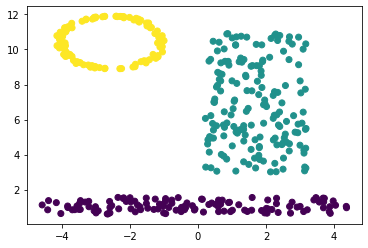

In [130]:
plt.scatter(table['x'], table['y'], c=table['class'])

In [131]:
y = table['class']
X = table.drop(['class'], axis=1)

In [132]:
enc = LabelEncoder()
y = enc.fit_transform(y)

Bez skalowania

In [133]:
nbc = clustering.NBC()
nbc.fit(X)

Najlepsza wartość parametru k:  32
Najlepsza wartość metryki ewaluacji:  0.9762317289626425


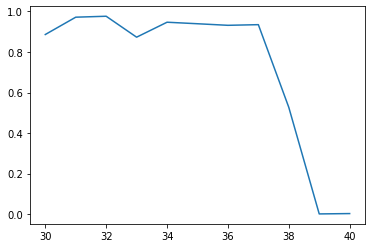

In [134]:
best_k, score = testing.find_best_predictions(X, y, nbc)
print('Najlepsza wartość parametru k: ', best_k)
print('Najlepsza wartość metryki ewaluacji: ', score)

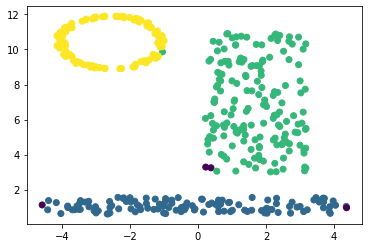

In [135]:
plt.scatter(table['x'], table['y'], c=nbc.predict(X, best_k))

Ze standaryzacją (odchylenie standardowe)

In [136]:
X_copy = X.copy()

In [137]:
scaler = StandardScaler()
X_copy[X_copy.columns] = scaler.fit_transform(X_copy[X_copy.columns])

In [138]:
nbc = clustering.NBC()
nbc.fit(X_copy)

Najlepsza wartość parametru k:  15
Najlepsza wartość metryki ewaluacji:  0.8613469552709685


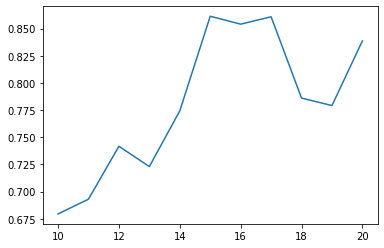

In [139]:
best_k, score = testing.find_best_predictions(X_copy, y, nbc)
print('Najlepsza wartość parametru k: ', best_k)
print('Najlepsza wartość metryki ewaluacji: ', score)

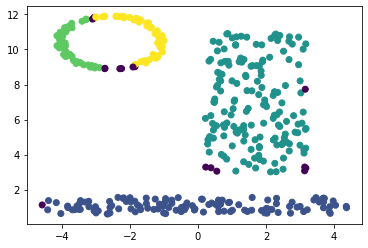

In [140]:
plt.scatter(table['x'], table['y'], c=nbc.predict(X_copy, best_k))

Ze standaryzacją (odchylenie przeciętne/bezwzględne)

In [141]:
def mad_standarization(column):
    mean = column.mean()
    mad = column.mad()
    return (column - mean) / mad

In [142]:
X_copy = X.copy()

In [143]:
X_copy = X_copy.apply(mad_standarization)

In [144]:
nbc = clustering.NBC()
nbc.fit(X_copy)

Najlepsza wartość parametru k:  17
Najlepsza wartość metryki ewaluacji:  0.8594204607265615


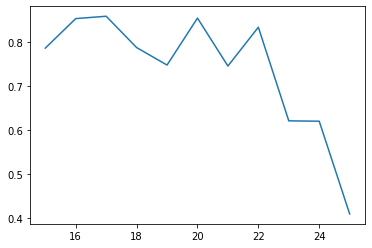

In [145]:
best_k, score = testing.find_best_predictions(X_copy, y, nbc)
print('Najlepsza wartość parametru k: ', best_k)
print('Najlepsza wartość metryki ewaluacji: ', score)

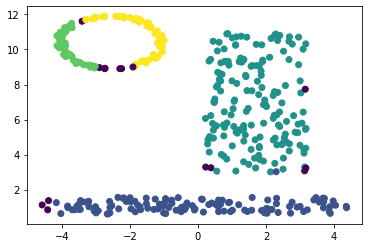

In [146]:
plt.scatter(table['x'], table['y'], c=nbc.predict(X_copy, best_k))

### Wnioski: skalowanie cech źle wpływa na uzyskiwane wyniki grupowania

### Badanie skuteczności algorytmu ze względu na różne stopnie metryki odległości

Stopień odległości l:  1
Najlepsza wartość parametru k:  19
Najlepsza wartość metryki ewaluacji:  0.8953627861618857

Stopień odległości l:  2
Najlepsza wartość parametru k:  32
Najlepsza wartość metryki ewaluacji:  0.9762317289626425

Stopień odległości l:  3
Najlepsza wartość parametru k:  31
Najlepsza wartość metryki ewaluacji:  0.9806612171612701

Stopień odległości l:  4
Najlepsza wartość parametru k:  30
Najlepsza wartość metryki ewaluacji:  0.9746651856580106

Stopień odległości l:  5
Najlepsza wartość parametru k:  30
Najlepsza wartość metryki ewaluacji:  0.9780193819026083



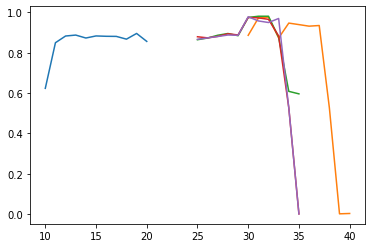

In [149]:
for l in range(1, 6):
    print('Stopień odległości l: ', l)
    nbc = clustering.NBC(l, 'optimized')
    nbc.fit(X)
    best_k, score = testing.find_best_predictions(X, y, nbc)
    print('Najlepsza wartość parametru k: ', best_k)
    print('Najlepsza wartość metryki ewaluacji: ', score)
    print()

# Badanie wpływu parametru k na czas oraz ostateczne wyniki grupowania

In [2]:
data = loadarff('datasets/dense-disk-3000.arff')
table = pd.DataFrame(data[0])

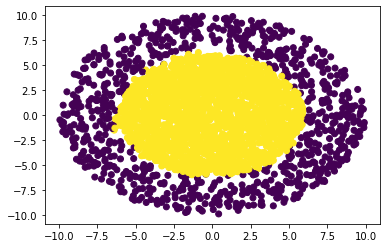

In [5]:
plt.scatter(table['x'], table['y'], c=table['CLASS'])

In [7]:
y = table['CLASS']
X = table.drop(['CLASS'], axis=1)

In [8]:
enc = LabelEncoder()
y = enc.fit_transform(y)

In [10]:
import time
k_values = np.arange(1, 50)
rand_values, davies_bouldin_values, silhouette_values, times = [], [], [], []
for k in k_values:
    start = time.time()
    nbc = clustering.NBC(method='optimized')
    nbc.fit(X)
    result = nbc.predict(X, k)
    stop = time.time()
    times.append(stop - start)
    rand_values.append(adjusted_rand_score(y, result))
    davies_bouldin_values.append(davies_bouldin_score(X, result))
    silhouette_values.append(silhouette_score(X, result))

In [25]:
result = nbc.predict(X, 11)

In [29]:
X_bez_szumu = X.iloc[(result != -1)]

In [36]:
adjusted_rand_score(y[result != -1], result[result != -1]), adjusted_rand_score(y, result)

(0.6614095006003722, 0.6355781877129586)

In [41]:
davies_bouldin_score(X_bez_szumu, y[result != -1]), davies_bouldin_score(X, y)

(35.056618097811736, 38.41115082092445)

In [42]:
silhouette_score(X_bez_szumu, y[result != -1]), silhouette_score(X, y)

(0.22951223469314558, 0.22425838393261388)

Text(0, 0.5, 'Czas w sekundach')

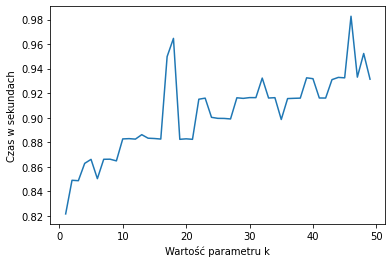

In [14]:
plt.plot(k_values, times)
plt.xlabel('Wartość parametru k')
plt.ylabel('Czas w sekundach')

Czas przetwarzania w zależności od parametru k rośnie liniowo nie uwzględniając szumu

Text(0, 0.5, 'Wartość metryki Rand')

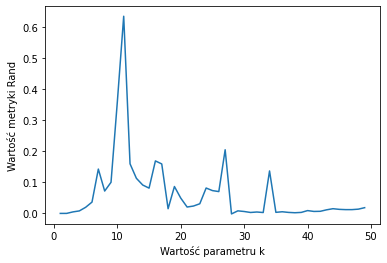

In [15]:
plt.plot(k_values, rand_values)
plt.xlabel('Wartość parametru k')
plt.ylabel('Wartość metryki Rand')

Wartość współczynnika wybija się wyraźnie w jednej konkretnej wartości k co nie dobrze wróży gdyż domaga się przeszukiwania przestrzeni parametru k w celu znalezienia satysfakcjonującego rozwiązania

Text(0, 0.5, 'Wartość metryki Davies-Bouldin')

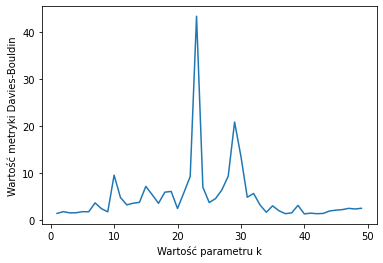

In [16]:
plt.plot(k_values, davies_bouldin_values)
plt.xlabel('Wartość parametru k')
plt.ylabel('Wartość metryki Davies-Bouldin')

Tu jest podobnie, ale dla innej wartości k. W tej metryce nie wysokie, ale niskie wartości są pożądane. Są one bliskie 0 dla albo bardzo małych albo bardzo dużych wielkości

Text(0, 0.5, 'Wartość metryki Silhouette')

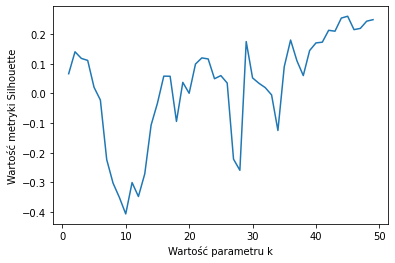

In [17]:
plt.plot(k_values, silhouette_values)
plt.xlabel('Wartość parametru k')
plt.ylabel('Wartość metryki Silhouette')

Mocne wahanie wskaźnika wskazuje na duży wpływ parametru ułożenie klastrów względem siebie. Przy wartości k takiej, gdzie dawała ona najlepsze wyniki w ewaluacji zewnętrznej metryka ta daje najniższe wyniki oznaczające ryzyko przypisania poszczególnych próbek do niewłaściwych klastrów, gdyż 0 wskazuje na nakładające się klastry. Może ona odzwierciedlać specyfikę zbioru - tego, że leżą one blisko siebie. Współczynnik ten jest z pewnością zaniżany przez szum, który jest w tym przypadku interpretowany jako grupa.

# Rzeczywisty zbiór mieszany

In [86]:
data = pd.read_csv('datasets/titanic.csv')

In [120]:
data = data.dropna().reset_index(drop=True)

In [121]:
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
1,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
2,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
3,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7000,G6,S
4,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S
...,...,...,...,...,...,...,...,...,...,...,...,...
178,872,1,1,"Beckwith, Mrs. Richard Leonard (Sallie Monypeny)",female,47.0,1,1,11751,52.5542,D35,S
179,873,0,1,"Carlsson, Mr. Frans Olof",male,33.0,0,0,695,5.0000,B51 B53 B55,S
180,880,1,1,"Potter, Mrs. Thomas Jr (Lily Alexenia Wilson)",female,56.0,0,1,11767,83.1583,C50,C
181,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S


In [154]:
y = data['Survived']
X = data[['Pclass','Age','SibSp','Parch','Fare']]

In [123]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183 entries, 0 to 182
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Pclass  183 non-null    int64  
 1   Age     183 non-null    float64
 2   SibSp   183 non-null    int64  
 3   Parch   183 non-null    int64  
 4   Fare    183 non-null    float64
dtypes: float64(2), int64(3)
memory usage: 7.3 KB


In [124]:
nbc = clustering.NBC(method='optimized')
nbc.fit(X)

Najlepsza wartość parametru k:  14
Najlepsza wartość metryki ewaluacji:  0.02978086356070694


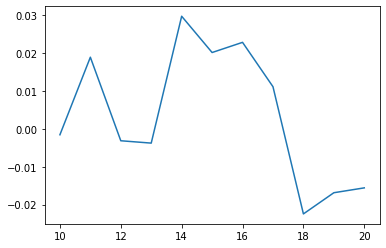

In [125]:
best_k, score = testing.find_best_predictions(X, y, nbc)
print('Najlepsza wartość parametru k: ', best_k)
print('Najlepsza wartość metryki ewaluacji: ', score)

In [126]:
y_pred = nbc.predict(X, 14)

In [162]:
np.unique(y_pred, return_counts=True)

(array([-1,  0,  1,  2]), array([14, 32, 58, 79], dtype=int64))

In [128]:
davies_bouldin_score(X, y_pred)

5.2361103853602184

In [129]:
silhouette_score(X, y_pred)

0.14955670318314232

In [155]:
encoder = OneHotEncoder()
X_enc = encoder.fit_transform(X[['Pclass', 'SibSp', 'Parch']])

In [139]:
encoder.categories_

[array([1, 2, 3], dtype=int64),
 array([0, 1, 2, 3], dtype=int64),
 array([0, 1, 2, 4], dtype=int64)]

In [143]:
encoder.get_feature_names(['Pclass', 'SibSp', 'Parch'])

array(['Pclass_1', 'Pclass_2', 'Pclass_3', 'SibSp_0', 'SibSp_1',
       'SibSp_2', 'SibSp_3', 'Parch_0', 'Parch_1', 'Parch_2', 'Parch_4'],
      dtype=object)

In [156]:
df_encoded = pd.DataFrame(X_enc.toarray(), columns=encoder.get_feature_names(['Pclass', 'SibSp', 'Parch']), dtype=np.int8)

In [157]:
X = pd.concat([X.drop(['Pclass', 'SibSp', 'Parch'], axis=1), df_encoded], axis=1)

In [158]:
X

,Age,Fare,Pclass_1,Pclass_2,Pclass_3,SibSp_0,SibSp_1,SibSp_2,SibSp_3,Parch_0,Parch_1,Parch_2,Parch_4
0,38.0,71.2833,1,0,0,0,1,0,0,1,0,0,0
1,35.0,53.1000,1,0,0,0,1,0,0,1,0,0,0
2,54.0,51.8625,1,0,0,1,0,0,0,1,0,0,0
3,4.0,16.7000,0,0,1,0,1,0,0,0,1,0,0
4,58.0,26.5500,1,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
178,47.0,52.5542,1,0,0,0,1,0,0,0,1,0,0
179,33.0,5.0000,1,0,0,1,0,0,0,1,0,0,0
180,56.0,83.1583,1,0,0,1,0,0,0,0,1,0,0
181,19.0,30.0000,1,0,0,1,0,0,0,1,0,0,0


In [159]:
nbc = clustering.NBC(method='optimized')
nbc.fit(X)

Najlepsza wartość parametru k:  14
Najlepsza wartość metryki ewaluacji:  0.02978086356070694


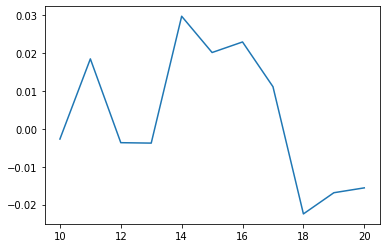

In [160]:
best_k, score = testing.find_best_predictions(X, y, nbc)
print('Najlepsza wartość parametru k: ', best_k)
print('Najlepsza wartość metryki ewaluacji: ', score)

### Wniosek: Algorytm nie jest wrażliwy na rangowanie w danych kategorycznych

In [163]:
X = X[['Age', 'Fare']]

In [165]:
nbc = clustering.NBC(method='optimized')
nbc.fit(X)

Najlepsza wartość parametru k:  14
Najlepsza wartość metryki ewaluacji:  0.033328059653843334


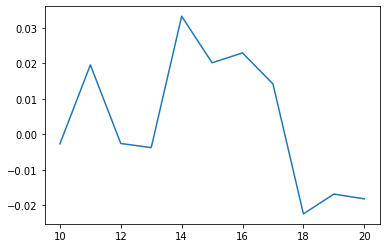

In [166]:
best_k, score = testing.find_best_predictions(X, y, nbc)
print('Najlepsza wartość parametru k: ', best_k)
print('Najlepsza wartość metryki ewaluacji: ', score)

In [167]:
y_pred = nbc.predict(X, 14)

In [168]:
np.unique(y_pred, return_counts=True)

(array([-1,  0,  1,  2]), array([13, 32, 58, 80], dtype=int64))

In [169]:
davies_bouldin_score(X, y_pred)

6.036839800617207

In [170]:
silhouette_score(X, y_pred)

0.1514828113475164

### Wniosek: usunięcie danych kategorycznych niemalże nie wpłynęło na wyniki

# Rzeczywisty zbiór numeryczny

In [ ]:
data = loadarff('datasets/vehicle.arff')
table = pd.DataFrame(data[0])

In [ ]:
table

,COMPACTNESS,CIRCULARITY,DISTANCE CIRCULARITY,RADIUS RATIO,PR.AXIS ASPECT RATIO,MAX.LENGTH ASPECT RATIO,SCATTER RATIO,ELONGATEDNESS,PR.AXIS RECTANGULARITY,MAX.LENGTH RECTANGULARITY,SCALED VARIANCE_MAJOR,SCALED VARIANCE_MINOR,SCALED RADIUS OF GYRATION,SKEWNESS ABOUT_MAJOR,SKEWNESS ABOUT_MINOR,KURTOSIS ABOUT_MAJOR,KURTOSIS ABOUT_MINOR,HOLLOWS RATIO,Class
0,95.0,48.0,83.0,178.0,72.0,10.0,162.0,42.0,20.0,159.0,176.0,379.0,184.0,70.0,6.0,16.0,187.0,197.0,b'van'
1,91.0,41.0,84.0,141.0,57.0,9.0,149.0,45.0,19.0,143.0,170.0,330.0,158.0,72.0,9.0,14.0,189.0,199.0,b'van'
2,104.0,50.0,106.0,209.0,66.0,10.0,207.0,32.0,23.0,158.0,223.0,635.0,220.0,73.0,14.0,9.0,188.0,196.0,b'saab'
3,93.0,41.0,82.0,159.0,63.0,9.0,144.0,46.0,19.0,143.0,160.0,309.0,127.0,63.0,6.0,10.0,199.0,207.0,b'van'
4,85.0,44.0,70.0,205.0,103.0,52.0,149.0,45.0,19.0,144.0,241.0,325.0,188.0,127.0,9.0,11.0,180.0,183.0,b'bus'
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
841,93.0,39.0,87.0,183.0,64.0,8.0,169.0,40.0,20.0,134.0,200.0,422.0,149.0,72.0,7.0,25.0,188.0,195.0,b'saab'
842,89.0,46.0,84.0,163.0,66.0,11.0,159.0,43.0,20.0,159.0,173.0,368.0,176.0,72.0,1.0,20.0,186.0,197.0,b'van'
843,106.0,54.0,101.0,222.0,67.0,12.0,222.0,30.0,25.0,173.0,228.0,721.0,200.0,70.0,3.0,4.0,187.0,201.0,b'saab'
844,86.0,36.0,78.0,146.0,58.0,7.0,135.0,50.0,18.0,124.0,155.0,270.0,148.0,66.0,0.0,25.0,190.0,195.0,b'saab'


In [ ]:
y = table['Class']
X = table.drop(['Class'], axis=1)

In [ ]:
correlation_matrix = X.corr().abs()
highly_correlated = (correlation_matrix >= 0.7)
columns_to_drop = set()
for i in range(len(highly_correlated.columns)):
    for j in range(i):
        if highly_correlated.iloc[i, j]:
            colname = correlation_matrix.columns[i]
            columns_to_drop.add(colname)

In [ ]:
X_filtered = X.drop(columns=columns_to_drop)

In [ ]:
nbc = clustering.NBC(method='optimized')
nbc.fit(X_filtered)

In [ ]:
enc = LabelEncoder()
y = enc.fit_transform(y)

Najlepsza wartość parametru k:  55
Najlepsza wartość metryki ewaluacji:  0.0007


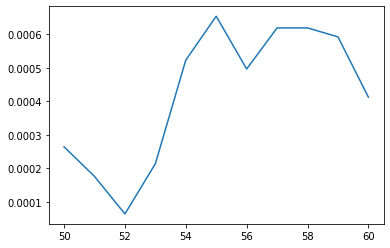

In [ ]:
best_k, score = testing.find_best_predictions(X_filtered, y, nbc)
print('Najlepsza wartość parametru k: ', best_k)
print('Najlepsza wartość metryki ewaluacji: ', score)

In [ ]:
np.unique(y)

array([0, 1, 2, 3])

In [ ]:
np.unique(nbc.predict(X, 55))

array([-1,  0])

### Wniosek: Wyniki klasyfikacji są złe głównie przez wykrywanie przez algorytm zmiennej liczby klas + szum. Dysproporcję pomiędzy liczbą rzeczywistych klas, a predykowaną można redukować wielkością parametru k dopóki grupy są dobrze separowalne (tak jak w przypadku przedstawionych zbiorów sztucznych). Techniki wstępnego przetwarzania nieuwzględniające tego faktu nic nie dadzą, gdyż wewnętrzną specyfiką algorytmu jest wykrywanie gęstych skupisk danych bez zważania na to, że pewne klasy mogą podzielać między sobą cechy podobieństwa.

# Skalowalność na podstawie dużego rzeczywistego zbioru kategorycznego

Najpierw klasyfikacja

In [74]:
data = pd.read_csv('datasets/us+census+data+1990/USCensus1990.data.txt', dtype=np.int32)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2458285 entries, 0 to 2458284
Data columns (total 69 columns):
 #   Column     Dtype
---  ------     -----
 0   caseid     int32
 1   dAge       int32
 2   dAncstry1  int32
 3   dAncstry2  int32
 4   iAvail     int32
 5   iCitizen   int32
 6   iClass     int32
 7   dDepart    int32
 8   iDisabl1   int32
 9   iDisabl2   int32
 10  iEnglish   int32
 11  iFeb55     int32
 12  iFertil    int32
 13  dHispanic  int32
 14  dHour89    int32
 15  dHours     int32
 16  iImmigr    int32
 17  dIncome1   int32
 18  dIncome2   int32
 19  dIncome3   int32
 20  dIncome4   int32
 21  dIncome5   int32
 22  dIncome6   int32
 23  dIncome7   int32
 24  dIncome8   int32
 25  dIndustry  int32
 26  iKorean    int32
 27  iLang1     int32
 28  iLooking   int32
 29  iMarital   int32
 30  iMay75880  int32
 31  iMeans     int32
 32  iMilitary  int32
 33  iMobility  int32
 34  iMobillim  int32
 35  dOccup     int32
 36  iOthrserv  int32
 37  iPerscare  int32
 38  dP

In [ ]:
y = data['iClass']
X = data.drop(['caseid','iClass'], axis=1)

In [ ]:
X.head()

,dAge,dAncstry1,dAncstry2,iAvail,iCitizen,dDepart,iDisabl1,iDisabl2,iEnglish,iFeb55,...,iTmpabsnt,dTravtime,iVietnam,dWeek89,iWork89,iWorklwk,iWWII,iYearsch,iYearwrk,dYrsserv
0,5,0,1,0,0,3,2,2,1,0,...,0,5,0,2,1,1,0,11,1,0
1,6,1,1,0,0,5,2,2,0,0,...,0,1,0,2,1,1,0,5,1,0
2,3,1,2,0,0,4,2,2,0,0,...,0,2,0,2,1,1,0,10,1,0
3,4,1,2,0,0,3,2,2,0,0,...,0,1,0,1,1,1,0,10,1,0
4,7,1,1,0,0,0,2,2,0,0,...,3,0,0,0,2,2,0,5,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2458280,7,1,2,0,0,0,2,2,0,0,...,3,0,0,0,2,2,1,7,5,1
2458281,1,1,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,4,0,0
2458282,3,3,1,0,0,2,2,2,1,0,...,0,5,0,2,1,1,0,11,1,0
2458283,6,0,1,0,0,3,2,2,0,0,...,0,1,0,2,1,1,0,10,1,0


In [ ]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

selector = SelectKBest(mutual_info_classif, k=5)
X_selected = selector.fit_transform(X, y)

In [ ]:
selected_features_mask = selector.get_support()

In [ ]:
X = X[X.columns[selected_features_mask]]

In [ ]:
X

,dIndustry,dOccup,iRlabor,iWork89,iYearwrk
0,10,3,1,1,1
1,4,2,1,1,1
2,1,4,1,1,1
3,4,2,1,1,1
4,0,0,6,2,6
...,...,...,...,...,...
2458280,0,0,6,2,5
2458281,0,0,0,0,0
2458282,6,5,1,1,1
2458283,5,2,1,1,1


In [ ]:
elements_amount = 10000
X_mod = X.iloc[:elements_amount]
y_mod = y[:elements_amount]

In [ ]:
nbc = clustering.NBC(method='optimized')
nbc.fit(X_mod)

Najlepsza wartość parametru k:  97
Najlepsza wartość metryki ewaluacji:  0.3620824429141635


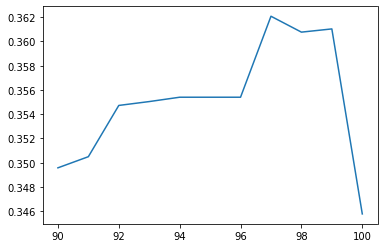

In [ ]:
best_k, score = testing.find_best_predictions(X_mod, y_mod, nbc, max_range=100)
print('Najlepsza wartość parametru k: ', best_k)
print('Najlepsza wartość metryki ewaluacji: ', score)

In [ ]:
result = nbc.predict(X_mod, 97)

In [ ]:
adjusted_rand_score(result, y_mod)

0.2604987101954372

In [ ]:
davies_bouldin_score(X_mod, result)

1.4663225370364839

In [ ]:
silhouette_score(X_mod, result)

0.7057100254032715

### Wniosek: Redukcja wymiarowości za pomocą informacji wzajemnej przyniosła dobre rezultaty. Lecz największą bolączką rozwiązania jest konieczność ograniczania liczby analizowanych elementów przez złożoność pamięciową przez co algorytm nie jest w stanie odpowiednio ocenić skupisk danych co niekorzystnie wpływa na wynik klasyfikacji

In [81]:
data = pd.read_csv('datasets/us+census+data+1990/USCensus1990.data.txt', dtype=np.uint8)

In [91]:
data = data.drop('iClass', axis=1)

In [92]:
data.shape

(2458285, 68)

## Skalowalność liczby elementów

In [95]:
data_test = data[['dAge']]

In [101]:
sizes = np.arange(1_000, 11_000, 1_000)

Metoda normalna (Vanilla Python)

In [ ]:
measures = [measure for measure in testing.measure_scalability(data_test, sizes, 'normal')]